# Introduction

Do higher film budgets lead to more box office revenue? Let's find out if there's a relationship using the movie budgets and financial performance data that I've scraped from [the-numbers.com](https://www.the-numbers.com/movie/budgets) on **May 1st, 2018**. 

<img src=https://i.imgur.com/kq7hrEh.png>

# Import Statements

In [99]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.linear_model import LinearRegression

# Notebook Presentation

In [2]:
pd.options.display.float_format = '{:,.2f}'.format

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Read the Data

In [3]:
data = pd.read_csv('cost_revenue_dirty.csv')

# Explore and Clean the Data

**Challenge**: Answer these questions about the dataset:
1. How many rows and columns does the dataset contain?
2. Are there any NaN values present?
3. Are there any duplicate rows?
4. What are the data types of the columns?

In [22]:
# %timeit data.info()
# %timeit data.info(show_counts=True)
# %timeit data[data.isna().any(axis=1)]
# # %timeit data[data.isna().any(axis=None)]
# %timeit data.isna().any().any()
# axis=None did not work. The two .info methods were equivalent, as were the .isna() methods 


In [26]:
print(data.shape)
print(data.info())
# print(data.nunique())
print(f'Any nan? {data[data.isna().any(axis=1)]}')
print(f"Duplicates: \n{data[data.duplicated(keep=False, subset=['Release_Date', 'Movie_Title'])]}")
data.sample(5)

(5391, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5391 entries, 0 to 5390
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Rank                   5391 non-null   int64 
 1   Release_Date           5391 non-null   object
 2   Movie_Title            5391 non-null   object
 3   USD_Production_Budget  5391 non-null   object
 4   USD_Worldwide_Gross    5391 non-null   object
 5   USD_Domestic_Gross     5391 non-null   object
dtypes: int64(1), object(5)
memory usage: 252.8+ KB
None
Any nan? Empty DataFrame
Columns: [Rank, Release_Date, Movie_Title, USD_Production_Budget, USD_Worldwide_Gross, USD_Domestic_Gross]
Index: []
Duplicates: 
      Rank Release_Date        Movie_Title USD_Production_Budget  \
3054  5289   12/31/2007  A Dog's Breakfast              $120,000   
3055  5290   12/31/2007  A Dog's Breakfast              $120,000   

     USD_Worldwide_Gross USD_Domestic_Gross  
3054         

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
3747,3227,10/2/2010,Triangle,"$12,000,000","$1,595,168",$0
62,3999,1/1/1954,The Egyptian,"$5,000,000","$15,000,000","$15,000,000"
2784,983,10/20/2006,Flags of Our Fathers,"$53,000,000","$63,657,941","$33,602,376"
3264,2582,11/4/2008,Prom Night,"$18,000,000","$57,193,655","$43,869,350"
2405,4109,4/3/2005,Dear Frankie,"$4,600,000","$3,099,369","$1,340,891"


### Data Type Conversions

**Challenge**: Convert the `USD_Production_Budget`, `USD_Worldwide_Gross`, and `USD_Domestic_Gross` columns to a numeric format by removing `$` signs and `,`. 
<br>
<br>
Note that *domestic* in this context refers to the United States.

In [27]:
data.USD_Domestic_Gross = data.USD_Domestic_Gross.str.replace(pat=r'\D', repl='', regex=True).astype(int)
data.USD_Production_Budget = data.USD_Production_Budget.str.replace(pat=r'\D', repl='', regex=True).astype(int)
data.USD_Worldwide_Gross = data.USD_Worldwide_Gross.str.replace(pat=r'\D', repl='', regex=True).astype(int)
data.sample(5)

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
646,4051,9/21/1992,Light Sleeper,5000000,1050861,1050861
1547,2029,12/15/2000,Chocolat,25000000,152500343,71309760
2783,5148,10/18/2006,51 Birch Street,350000,84689,84689
3573,5015,1/26/2010,B-Girl,700000,1160,0
2285,392,9/4/2004,The Alamo,92000000,23911362,22406362


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5391 entries, 0 to 5390
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Rank                   5391 non-null   int64 
 1   Release_Date           5391 non-null   object
 2   Movie_Title            5391 non-null   object
 3   USD_Production_Budget  5391 non-null   int64 
 4   USD_Worldwide_Gross    5391 non-null   int64 
 5   USD_Domestic_Gross     5391 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 252.8+ KB


**Challenge**: Convert the `Release_Date` column to a Pandas Datetime type. 

In [29]:
data.Release_Date = pd.to_datetime(data.Release_Date)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5391 entries, 0 to 5390
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Rank                   5391 non-null   int64         
 1   Release_Date           5391 non-null   datetime64[ns]
 2   Movie_Title            5391 non-null   object        
 3   USD_Production_Budget  5391 non-null   int64         
 4   USD_Worldwide_Gross    5391 non-null   int64         
 5   USD_Domestic_Gross     5391 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 252.8+ KB


In [30]:
# Did not drop the duplicate above since it was not part of the challenge. 
# Will do it here.
data = data.drop_duplicates(subset=['Release_Date', 'Movie_Title'])
print(f"Duplicates: \n{data[data.duplicated(keep=False, subset=['Release_Date', 'Movie_Title'])]}")
data.info()

Duplicates: 
Empty DataFrame
Columns: [Rank, Release_Date, Movie_Title, USD_Production_Budget, USD_Worldwide_Gross, USD_Domestic_Gross]
Index: []
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5390 entries, 0 to 5390
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Rank                   5390 non-null   int64         
 1   Release_Date           5390 non-null   datetime64[ns]
 2   Movie_Title            5390 non-null   object        
 3   USD_Production_Budget  5390 non-null   int64         
 4   USD_Worldwide_Gross    5390 non-null   int64         
 5   USD_Domestic_Gross     5390 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 294.8+ KB


### Descriptive Statistics

**Challenge**: 

1. What is the average production budget of the films in the data set?
2. What is the average worldwide gross revenue of films?
3. What were the minimums for worldwide and domestic revenue?
4. Are the bottom 25% of films actually profitable or do they lose money?
5. What are the highest production budget and highest worldwide gross revenue of any film?
6. How much revenue did the lowest and highest budget films make?

In [39]:
print(f'Avg Prod Budget: {data.USD_Production_Budget.mean()}')
print(f'Avg Worldwide Gross Rev: {data.USD_Worldwide_Gross.mean()}')
# Getting too bored to type all these out. I think describe() gives us all of the above.
print(data.describe())
# I think the only question not answered by describe() is #6
# #6 Lowest
print(f'Lowest Budget Film:')
data[data.USD_Production_Budget == data.USD_Production_Budget.min()]


Avg Prod Budget: 31119487.807977736
Avg Worldwide Gross Rev: 88871907.19870129
          Rank  USD_Production_Budget  USD_Worldwide_Gross  USD_Domestic_Gross
count 5,390.00               5,390.00             5,390.00            5,390.00
mean  2,695.52          31,119,487.81        88,871,907.20       41,243,169.82
std   1,556.14          40,525,356.93       168,469,037.10       66,033,082.74
min       1.00               1,100.00                 0.00                0.00
25%   1,348.25           5,000,000.00         3,877,146.00        1,335,065.75
50%   2,695.50          17,000,000.00        27,460,037.00       17,196,565.00
75%   4,042.75          40,000,000.00        96,461,821.00       52,348,661.50
max   5,391.00         425,000,000.00     2,783,918,982.00      936,662,225.00
Lowest Budget Film:


,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
2427,5391,2005-05-08,My Date With Drew,1100,181041,181041


In [40]:
# 6 Highest
print(f'Highest Budget Film:')
data[data.USD_Production_Budget == data.USD_Production_Budget.max()]

Highest Budget Film:


,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
3529,1,2009-12-18,Avatar,425000000,2783918982,760507625


# Investigating the Zero Revenue Films

**Challenge** How many films grossed $0 domestically (i.e., in the United States)? What were the highest budget films that grossed nothing?

In [41]:
data[data.USD_Domestic_Gross == 0].sort_values(by='USD_Production_Budget', ascending=False)

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
5388,96,2020-12-31,Singularity,175000000,0,0
5387,126,2018-12-18,Aquaman,160000000,0,0
5384,321,2018-09-03,A Wrinkle in Time,103000000,0,0
5385,366,2018-10-08,Amusement Park,100000000,0,0
5090,556,2015-12-31,"Don Gato, el inicio de la pandilla",80000000,4547660,0
...,...,...,...,...,...,...
4787,5371,2014-12-31,Stories of Our Lives,15000,0,0
3056,5374,2007-12-31,Tin Can Man,12000,0,0
4907,5381,2015-05-19,Family Motocross,10000,0,0
5006,5389,2015-09-29,Signed Sealed Delivered,5000,0,0


**Challenge**: How many films grossed $0 worldwide? What are the highest budget films that had no revenue internationally?

In [42]:
data[data.USD_Worldwide_Gross == 0].sort_values(by='USD_Production_Budget', ascending=False)

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
5388,96,2020-12-31,Singularity,175000000,0,0
5387,126,2018-12-18,Aquaman,160000000,0,0
5384,321,2018-09-03,A Wrinkle in Time,103000000,0,0
5385,366,2018-10-08,Amusement Park,100000000,0,0
5338,879,2017-04-08,The Dark Tower,60000000,0,0
...,...,...,...,...,...,...
4787,5371,2014-12-31,Stories of Our Lives,15000,0,0
3056,5374,2007-12-31,Tin Can Man,12000,0,0
4907,5381,2015-05-19,Family Motocross,10000,0,0
5006,5389,2015-09-29,Signed Sealed Delivered,5000,0,0


### Filtering on Multiple Conditions

In [44]:
intl_rels = data.loc[(data.USD_Worldwide_Gross != 0) &
                     (data.USD_Domestic_Gross == 0)]
print(f'Number of International-Only Releases: {len(intl_rels)}')
intl_rels.sample(5)

Number of International-Only Releases: 155


,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
5322,2946,2017-02-17,In Dubious Battle,15000000,4892,0
3414,4074,2009-07-07,Flying By,5000000,4568257,0
4694,2945,2014-10-10,Automata,15000000,29050,0
4012,4158,2011-10-21,Cargo,4200000,313230,0
2409,4747,2005-04-11,Wal-Mart: The High Cost of Low Price,1500000,58692,0


**Challenge**: Use the [`.query()` function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.query.html) to accomplish the same thing. Create a subset for international releases that had some worldwide gross revenue, but made zero revenue in the United States. 

Hint: This time you'll have to use the `and` keyword.

In [46]:
intl_only = data.query(expr='(USD_Worldwide_Gross != 0) and (USD_Domestic_Gross == 0)')
print(f'Number of International-Only Releases: {len(intl_only)}')
intl_only.sample(5)

Number of International-Only Releases: 155


,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
5340,1506,2017-04-14,Queen of the Desert,36000000,1480089,0
3899,4780,2011-05-24,Forget Me Not,1300000,13465,0
2155,4236,2003-12-31,Nothing,4000000,63180,0
5271,1433,2016-11-11,USS Indianapolis: Men of Courage,40000000,1079040,0
5174,2649,2016-04-15,I Am Wrath,18000000,6784,0


### Unreleased Films

**Challenge**:
* Identify which films were not released yet as of the time of data collection (May 1st, 2018).
* How many films are included in the dataset that have not yet had a chance to be screened in the box office? 
* Create another DataFrame called data_clean that does not include these films. 

In [53]:
# Date of Data Collection
scrape_date = pd.Timestamp('2018-5-1')
unreleased = data.query('Release_Date > @scrape_date')
print(f'As of the date of data collection - {scrape_date} - {len(unreleased)} unreleased films were in the data set')
unreleased

As of the date of data collection - 2018-05-01 00:00:00 - 7 unreleased films were in the data set


,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
5384,321,2018-09-03,A Wrinkle in Time,103000000,0,0
5385,366,2018-10-08,Amusement Park,100000000,0,0
5386,2950,2018-10-08,Meg,15000000,0,0
5387,126,2018-12-18,Aquaman,160000000,0,0
5388,96,2020-12-31,Singularity,175000000,0,0
5389,1119,2020-12-31,Hannibal the Conqueror,50000000,0,0
5390,2517,2020-12-31,"Story of Bonnie and Clyde, The",20000000,0,0


In [54]:
# unreleased.index
data_clean = data.drop(unreleased.index)
data_clean.tail(5)

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
5379,1295,2017-10-02,John Wick: Chapter Two,40000000,166893990,92029184
5380,70,2017-10-03,Kong: Skull Island,185000000,561137727,168052812
5381,94,2017-12-05,King Arthur: Legend of the Sword,175000000,140012608,39175066
5382,1254,2017-12-05,Snatched,42000000,57850343,45850343
5383,2521,2017-12-31,The Thousand Miles,20000000,0,0


### Films that Lost Money

**Challenge**: 
What is the percentage of films where the production costs exceeded the worldwide gross revenue? 

In [55]:
losers  = data_clean.query(expr='USD_Worldwide_Gross < USD_Production_Budget')
print(f'{(len(losers)/len(data_clean)):.2%} of films lost money')

37.27% of films lost money


# Seaborn for Data Viz: Bubble Charts

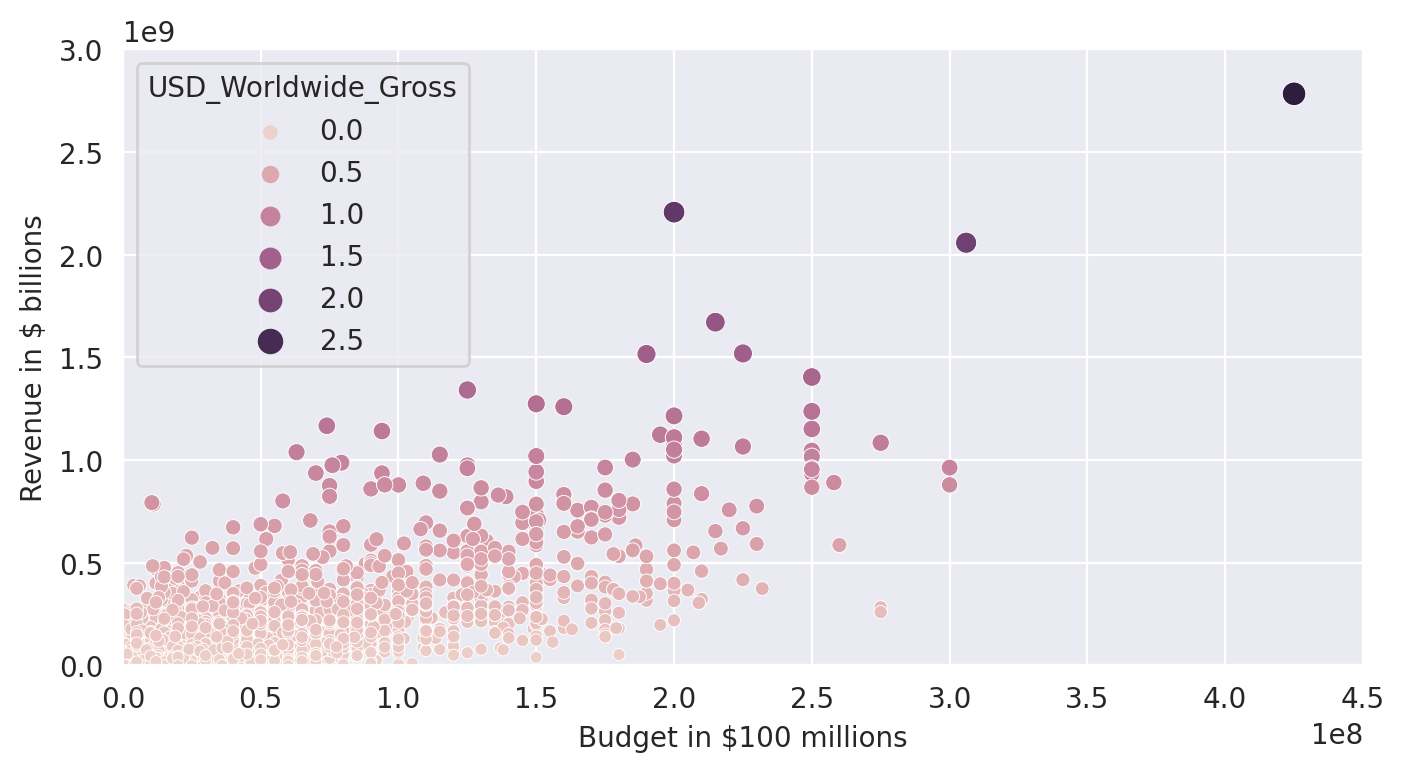

In [68]:
# First look at scatter plots. See how Seaborn is built on MatPlotLib, 
# this allows delving into MatPlotLib (plt) for configuration, etc.

plt.figure(figsize=(8,4), dpi=200)
# set styling on a single chart
with sns.axes_style('darkgrid'):
       ax = sns.scatterplot(data=data_clean, 
                            x='USD_Production_Budget', 
                            y='USD_Worldwide_Gross', # next lines change scatterplot to bubble 
                            hue='USD_Worldwide_Gross', # color
                            size='USD_Worldwide_Gross') # dot size

       ax.set(ylim=(0, 3000000000),
              xlim=(0, 450000000),
              ylabel='Revenue in $ billions',
              xlabel='Budget in $100 millions')
# plt.show()

### Plotting Movie Releases over Time

**Challenge**: Try to create the following Bubble Chart:

<img src=https://i.imgur.com/8fUn9T6.png>



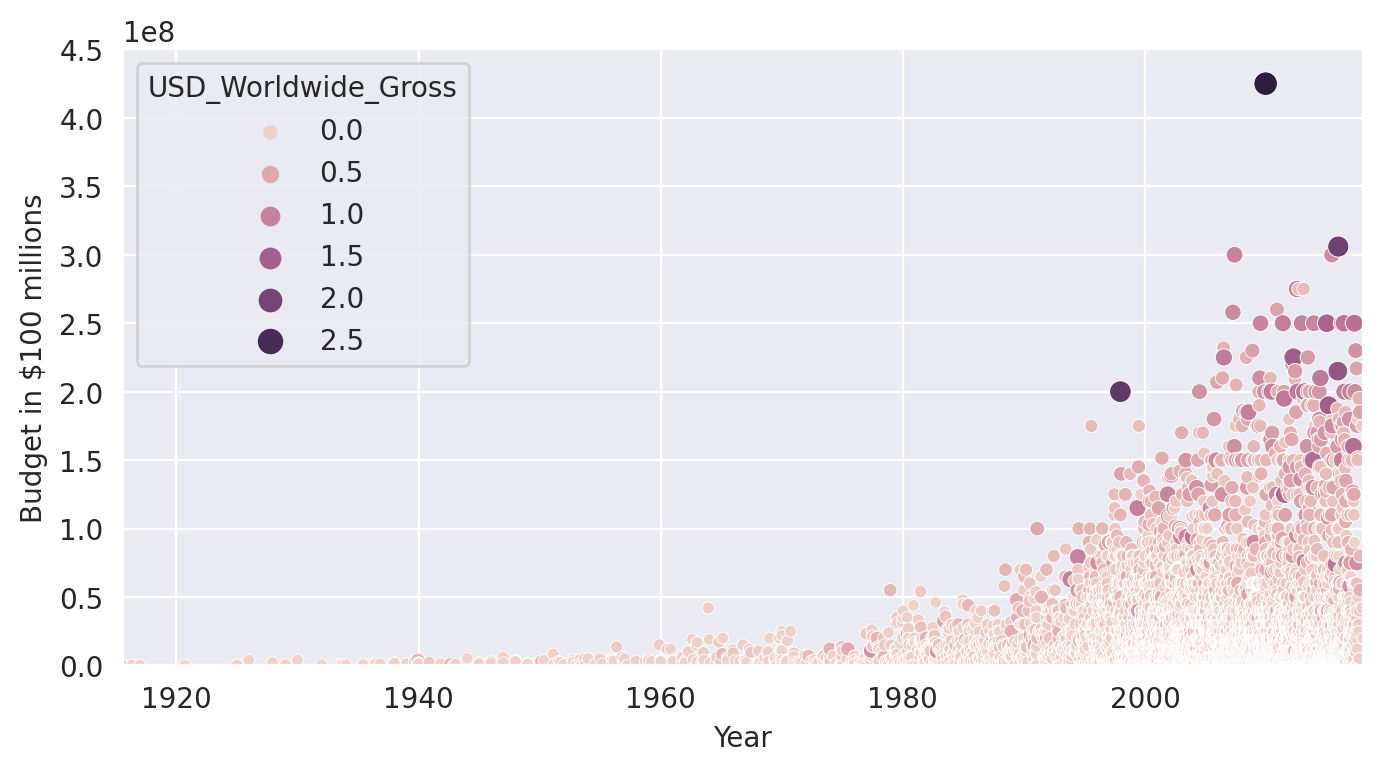

In [79]:
fig = plt.figure(figsize=(8,4), dpi=200)

with sns.axes_style('darkgrid'):
       ax = sns.scatterplot(data=data_clean, 
                            x='Release_Date', 
                            y='USD_Production_Budget', # next lines change scatterplot to bubble 
                            hue='USD_Worldwide_Gross', # color
                            size='USD_Worldwide_Gross') # dot size

       ax.set(ylim=(0, 450000000),
              xlim=(data_clean.Release_Date.min(), data_clean.Release_Date.max()),
              ylabel='Budget in $100 millions',
              xlabel='Year')
       # fig.set_alpha(0.0)

# Converting Years to Decades Trick

**Challenge**: Create a column in `data_clean` that has the decade of the release. 

<img src=https://i.imgur.com/0VEfagw.png width=650> 

Here's how: 
1. Create a [`DatetimeIndex` object](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html) from the Release_Date column. 
2. Grab all the years from the `DatetimeIndex` object using the `.year` property.
<img src=https://i.imgur.com/5m06Ach.png width=650>
3. Use floor division `//` to convert the year data to the decades of the films.
4. Add the decades as a `Decade` column to the `data_clean` DataFrame.

In [80]:
data_clean['Decade'] = data_clean.Release_Date.dt.year // 10 * 10
data_clean.sample(10)

# Class example was to do the following - I think the above was simpler and :
# dt_index = pd.DatetimeIndex(data_clean.Release_Date)
# years = dt_index.year
# decades = years//10*10
# data_clean['Decade'] = decades

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross,Decade
4844,59,2015-03-04,Furious 7,190000000,1516748684,351032910,2010
4634,2828,2014-07-11,The Theory of Everything,15000000,123327692,35893537,2010
4098,2775,2012-02-11,Vamps,16000000,94812,3361,2010
3007,2846,2007-11-05,28 Weeks Later,15000000,64232714,28638916,2000
549,2595,1989-12-13,Glory,18000000,26593580,26593580,1980
1293,1639,1999-08-27,The Astronaut's Wife,34000000,10672566,10672566,1990
0,5293,1915-08-02,The Birth of a Nation,110000,11000000,10000000,1910
3106,3335,2008-03-10,Nick and Norah's Infinite Playlist,10000000,33886017,31487293,2000
950,1617,1997-02-05,Warriors of Virtue,35000000,6448817,6448817,1990
1716,3263,2001-11-21,Out Cold,11000000,14786394,13906394,2000


### Separate the "old" (before 1969) and "New" (1970s onwards) Films

**Challenge**: Create two new DataFrames: `old_films` and `new_films`
* `old_films` should include all the films before 1969 (up to and including 1969)
* `new_films` should include all the films from 1970 onwards
* How many films were released prior to 1970?
* What was the most expensive film made prior to 1970?

In [83]:
old_films = data_clean.query('Decade < 1970')
new_films = data_clean.query('Decade >= 1970')


In [88]:
print(f'{len(old_films)} films were released before 1970.')
print(f'The most expensive film < 1970 was:')
# old_films.info()
old_films.loc[old_films.USD_Production_Budget.idxmax()]

153 films were released before 1970.
The most expensive film < 1970 was:


Rank                                    1253
Release_Date             1963-12-06 00:00:00
Movie_Title                        Cleopatra
USD_Production_Budget               42000000
USD_Worldwide_Gross                 71000000
USD_Domestic_Gross                  57000000
Decade                                  1960
Name: 109, dtype: object

In [89]:
old_films.describe()

,Rank,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross,Decade
count,153.00,153.00,153.00,153.00,153.00
mean,"4,274.77","4,611,297.65","30,419,634.38","22,389,473.87","1,949.15"
std,742.14,"5,713,648.85","54,931,828.93","32,641,752.41",12.72
min,"1,253.00","100,000.00",0.00,0.00,"1,910.00"
25%,"3,973.00","1,250,000.00","5,273,000.00","5,000,000.00","1,940.00"
50%,"4,434.00","2,900,000.00","10,000,000.00","10,000,000.00","1,950.00"
75%,"4,785.00","5,000,000.00","33,208,099.00","28,350,000.00","1,960.00"
max,"5,299.00","42,000,000.00","390,525,192.00","198,680,470.00","1,960.00"


In [90]:
old_films.sort_values(by='USD_Production_Budget', ascending=False).head()

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross,Decade
109,1253,1963-12-06,Cleopatra,42000000,71000000,57000000,1960
150,2175,1969-12-16,"Hello, Dolly",24000000,33208099,33208099,1960
143,2465,1969-01-01,Sweet Charity,20000000,8000000,8000000,1960
118,2425,1965-02-15,The Greatest Story Ever Told,20000000,15473333,15473333,1960
148,2375,1969-10-15,Paint Your Wagon,20000000,31678778,31678778,1960


# Seaborn Regression Plots

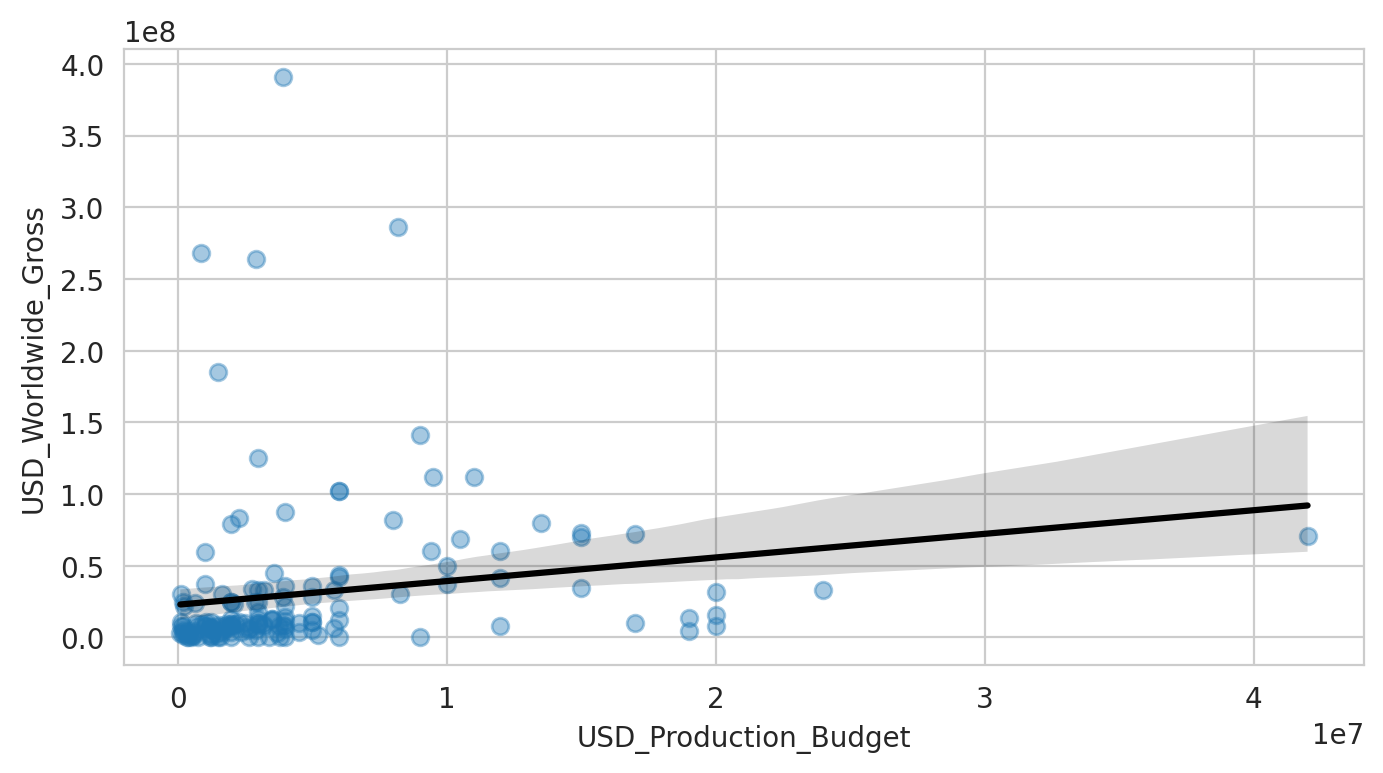

In [92]:
plt.figure(figsize=(8,4), dpi=200)
with sns.axes_style("whitegrid"):
    sns.regplot(data=old_films, 
                x='USD_Production_Budget', 
                y='USD_Worldwide_Gross',
                scatter_kws = {'alpha': 0.4},
                line_kws = {'color': 'black'})

**Challenge**: Use Seaborn's `.regplot()` to show the scatter plot and linear regression line against the `new_films`. 
<br>
<br>
Style the chart

* Put the chart on a `'darkgrid'`.
* Set limits on the axes so that they don't show negative values.
* Label the axes on the plot "Revenue in \$ billions" and "Budget in \$ millions".
* Provide HEX colour codes for the plot and the regression line. Make the dots dark blue (#2f4b7c) and the line orange (#ff7c43).

Interpret the chart

* Do our data points for the new films align better or worse with the linear regression than for our older films?
* Roughly how much would a film with a budget of $150 million make according to the regression line?

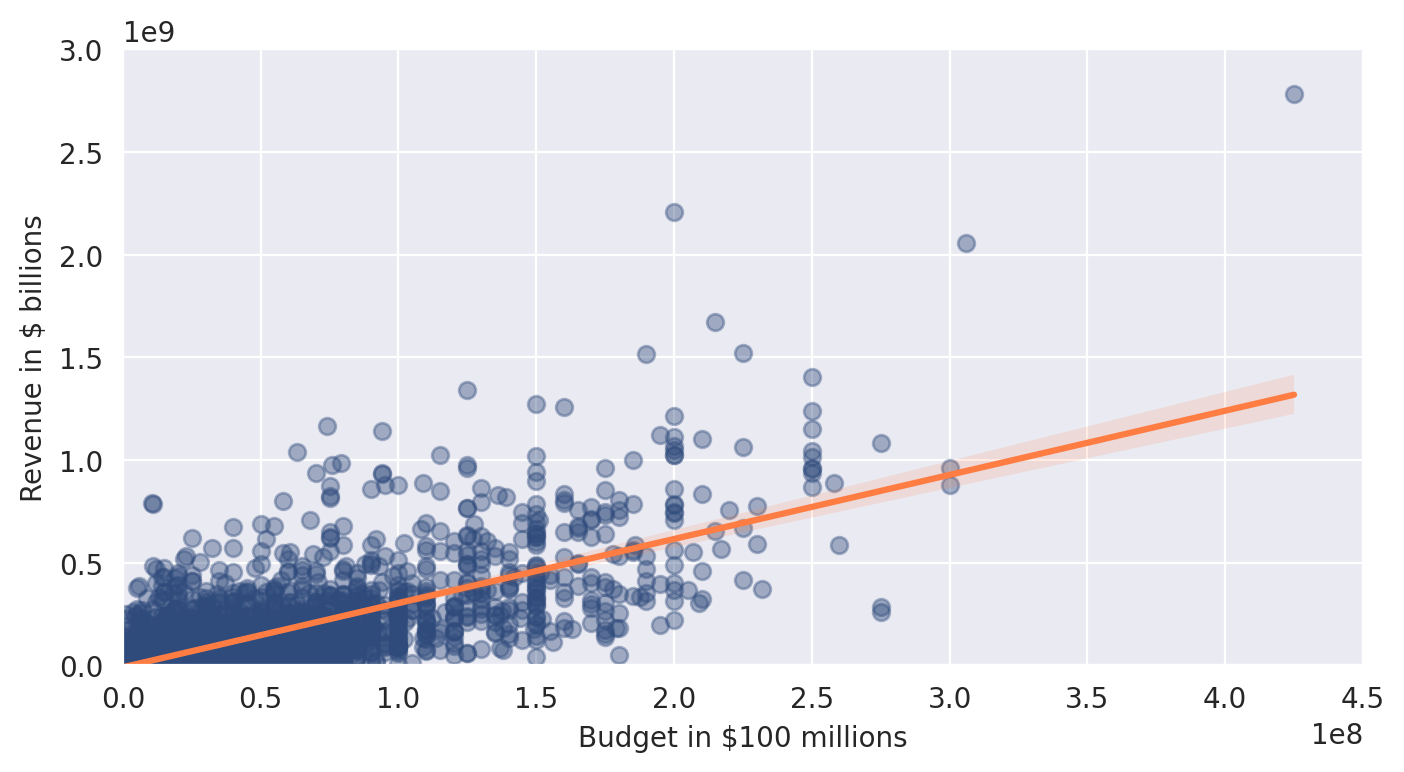

In [98]:
plt.figure(figsize=(8,4), dpi=200)
with sns.axes_style("darkgrid"):
    ax = sns.regplot(data=new_films, 
                     x='USD_Production_Budget', 
                     y='USD_Worldwide_Gross',
                     scatter_kws = {'alpha': 0.4,
                                    'color': '#2f4b7c'},
                     line_kws = {'color': '#ff7c43'})
    ax.set(xlabel= 'Budget in $100 millions',
           ylabel= 'Revenue in $ billions',
           ylim= (0, 3000000000),
           xlim= (0, 450000000))

At lower budget levels, the newer films conformed to the regression line more closely than the older ones did.

However, whereas with older films the obvious over performers were at lower budget levels, with newer films, there were more over-performers at higher budget levels, and fewer under-performers. 

I would imagine that much of this budget went to marketing, which was not as developed `< 1970`.

# Run Your Own Regression with scikit-learn

$$ REV \hat ENUE = \theta _0 + \theta _1 BUDGET$$

In [113]:
regression = LinearRegression()
x = new_films[['USD_Production_Budget']]
y = new_films[['USD_Worldwide_Gross']]
regression.fit(x, y)
print(regression.intercept_)
print(regression.coef_)
print(regression.score(x, y))

[-8653311.20858927]
[[3.12262611]]
0.5576797626619334


**Challenge**: Run a linear regression for the `old_films`. Calculate the intercept, slope and r-squared. How much of the variance in movie revenue does the linear model explain in this case?

In [112]:
regression_old = LinearRegression()
x_old = old_films[['USD_Production_Budget']]
y_old = old_films[['USD_Worldwide_Gross']]
regression_old.fit(x_old, y_old)
print(regression_old.intercept_)
print(regression_old.coef_)
print(regression_old.score(x_old, y_old))

[22821538.63508039]
[[1.64771314]]
0.02937258620576877


# Use Your Model to Make a Prediction

We just estimated the slope and intercept! Remember that our Linear Model has the following form:

$$ REV \hat ENUE = \theta _0 + \theta _1 BUDGET$$

**Challenge**:  How much global revenue does our model estimate for a film with a budget of $350 million? 

In [123]:
budget = 350000000
estimate = regression_old.intercept_[0] + regression_old.coef_[0,0] * budget
estimate = round(estimate, -6)
print(f'The estimated revenue for a $350M film produced < 1970 is around ${estimate:,.10}.')
# regression.coef_

The estimated revenue for a $350M film produced < 1970 is around $600,000,000.0.
